# Analyze  Integrations for MSS19 (LC5 step 2) AD predictions

In [1]:
from Bio.Seq import Seq
from Bio.Alphabet import generic_dna
import pandas as pd
import numpy as np
import itertools
import re
from collections import defaultdict 
import matplotlib.pyplot as plt

## reverse complement funciton
revcompl = lambda x: ''.join([{'A':'T','C':'G','G':'C','T':'A'," ":'N'}[B] for B in x][::-1])

### MAP OF OLIGO POOL

#### 2xBC
    TTCTTCTGA[6xN-integration BC][NheI][9 bp designed AD BC][XhoI]
    
#### Random BCs
    TTCTTCTGA[NheI][12xN random BC][XhoI]

In [2]:
REsiteDictionary = { 
        'CTTAAG':'AflII','GGATCC':'BamHI',
        'GCTAGC':'NheI','GAGCTC':'SacI',
        'CTCGAG':'XhoI','GAATTC':'EcoRI'}
REsiteDict_Reverse = {v: k for k, v in REsiteDictionary.iteritems()}


UpstreamClusterGREP = 'GCCACCATG'
DownStreamClusterGREP = REsiteDict_Reverse['XhoI']
SeqBeforeAD = 'accatg'.upper()
RESiteBeforeAD =REsiteDict_Reverse['AflII']
# ADlength = VARIABLE
RESiteAfterAD = REsiteDict_Reverse['BamHI']
RESiteBeforeBC  = REsiteDict_Reverse['NheI']
BClength = 9 # for designed BCs. Different length for random. #randBCs are 11 bp
RESiteAfterBC = REsiteDict_Reverse['XhoI']
SeqAtEnd = 'TGTATGCTAT'
# Insert_End_Position = #Very variable in this library



firstcodonposition = 16
Insert_Start_Position = 10



In [3]:
## read in designed array
filename = '../../../ArrayDesign/Array4_predictedADs/output/Staller_Array4_20200804v2.txt'
handle = open(filename,'r')
ArraySeqs = handle.readlines()
handle.close()

InsertLengths = []
DesignedInserts = []
DesignedADs =[] # DNA
DesignedBCs = [] # DNA
DesignedADs_AA =[] #AA
for line in ArraySeqs:
    matcher = re.search(UpstreamClusterGREP,line)
    Insert_Start_Position = matcher.start()
    ## USE THE XhoI site after the BC as the end of the insert because GREP on the cluster cuts the sequence off at this position
    seqtouseatend = DownStreamClusterGREP
    matcher = re.search(seqtouseatend,line)
    Insert_End_Position = matcher.start()
    insert = line[Insert_Start_Position:Insert_End_Position+len(seqtouseatend)]
    InsertLengths.append(len(insert))
#     if len(insert) <190:
    DesignedInserts.append(insert) # with the RE sites # updated 201912
    
    ADEnd = re.search(RESiteAfterAD,line)
    adseq_DNA= line[firstcodonposition:ADEnd.start()-len(RESiteAfterAD)] ##DNA 
    DesignedADs.append(adseq_DNA) # AD seqs
    
    # barcodes
    BeforeBC = re.search(RESiteBeforeBC,line)
    DesignedBCs.append(line[BeforeBC.start()+len(RESiteBeforeAD):Insert_End_Position]) # Barcodes
    
    # translate
    CDS = Seq(adseq_DNA, generic_dna)  #sequence object
    tempAA = str(CDS.translate()) # protein
    DesignedADs_AA.append(tempAA) # AA list
# DesignedBCs[0:10]

In [4]:
#compoundBCs
UpstreamClusterGREP = 'TTCTTCTGA'
SeqAtStart ='TTCTTCTGA' # Grep used on cluster
RESiteBtwBCs  = REsiteDict_Reverse['NheI']
DownStreamClusterGREP = REsiteDict_Reverse['XhoI'] #for 1x50 bp read, RE at end is cut off #REsiteDict_Reverse['XhoI']


#randomBCs
RESiteBeforeBC  = REsiteDict_Reverse['NheI']

DesignedADs_AA[0]

'MVEDYLASGYQDSVTFDDVAVDFTPEEWALLDTTEKYLY'

# analyze Compound Barcode
begun 20201103

In [5]:
def AnalyzeInserts(inputfilename,ReadCountThreshold,returnDF=0,debugging=0,plotReadDepthHist=0,returnFullSeq2CountDict=0):
    myfile  = open(inputfilename,'r')
    MasterSeqList = myfile.readlines()
    myfile.close()

    SeqAbundances = []
    FullSeq2CountDict =defaultdict(int)
#     InsertSeqReads =[]
    TotalReads =0
    SeqsAnalyzed =[]
    InsertionBC_list,ADBC_list =[],[]
    ReadsWithErrorsInRESiteBtwBCs,ReadsWithErrorsInRESiteBtwBCs_counts =[],0 # keep track of seq errors and SNPs
#     ADReads =[]
#     ADReads_AA =[]
    BCReads= []
#     BCReads_overThresh = []
#     ReadLengths =[]
#     MatchCount = 0
#     MatchCount_readcount =0
#     k = 0
#     Candidates =[]
    BCmatches = 0
    BCmatches_seqs=[]
    BCmatches_readcount=0
#     ADmatches = 0
#     ADmatches_readcount =0
#     ADmatches_seqs =[]
#     BarcodesCorrespond =0
#     BarcodesCorrespond_Readcount =0
#     perfectmatchReads = 0
#     ShortReadCounter =0
#     AD_AAmatches =0
#     AD_AAmatches_readcount =0
    
    for line in MasterSeqList:
        count, seq = line.split()
        count = int(count)
        TotalReads +=count
        if count >ReadCountThreshold: #Threshold for number of reads
            # TTCTTCTGA[6xN-integration BC][NheI][9 bp designed AD BC][XhoI]
            # because of cluster GREP all seqs must have 'TTCTTCTGA' and 'XhoI'
            if(re.search(RESiteBtwBCs,seq) and re.search(DownStreamClusterGREP,seq)):
                #separate the compound BC
                temp = re.search(SeqAtStart,seq)
                InsertionBCstart = temp.start()+len(SeqAtStart)
                temp = re.search(RESiteBtwBCs,seq)
                InsertionBCend = temp.start()
                AD_BCstart = temp.start()+len(RESiteBtwBCs)
#                 temp   = re.search(RESiteAfterBC,seq)
                temp   = re.search(DownStreamClusterGREP,seq)

                AD_BCend   = temp.start()
                InsertionBC = seq[InsertionBCstart:InsertionBCend] 
                ADBC = seq[AD_BCstart:AD_BCend]
                
                # Record lists of IntegrationBC and ADBC pairs
                SeqAbundances.append(count)
                SeqsAnalyzed.append(seq)
                FullSeq2CountDict[seq]=count
                InsertionBC_list.append(InsertionBC)
                ADBC_list.append(ADBC)
                
                if debugging:
                    print 
                    print InsertionBC +'\t integration Barcode'
                    print ADBC+'\t AD Barcode'
            

                # determine fraction of barcodes that match designed barcodes
                if ADBC in DesignedBCs:
                    BCmatches=BCmatches+1 
                    BCmatches_seqs.append(ADBC)
                    BCmatches_readcount = BCmatches_readcount+count
            else:
                ReadsWithErrorsInRESiteBtwBCs.append(seq)
                ReadsWithErrorsInRESiteBtwBCs_counts +=count
                
                
    if returnDF==1:
        ProcessedReadsDF= pd.DataFrame({'ADBCs':ADBC_list,'InsertionBCs':InsertionBC_list,'Counts':SeqAbundances,'FullSeqs':SeqsAnalyzed})
        
        #assess how many integration BCs each ADBC has.(asess complexity)
        #very slow
#         ADBC_to_InsertionBCCount_Dict ={}
#         complexitycounts =[]
#         for adbc in set(ADBC_list):
#             indx = ProcessedReadsDF.ADBCs==adbc
#             ADBC_to_InsertionBCCount_Dict[adbc]=sum(indx)
#             complexitycounts.append(sum(indx))

    TotalReadsAnalyzed = sum(SeqAbundances)
    PercentReadsAnalyzed = 100.0*TotalReadsAnalyzed/TotalReads
    BCmatch_percent = 100*BCmatches_readcount/TotalReads

    print '\n'+inputfilename
    print "The Read Count Threshold is: %i" % ReadCountThreshold
    print "There are %i total reads. %i reads were analyzed at this threshold %.2f percent"%(TotalReads,TotalReadsAnalyzed,PercentReadsAnalyzed)
    print "%i of %i AD Barcode Seqs Match Designed AD Barcodes " % (BCmatches, len(SeqAbundances))    
    print "There are %i unique AD Barcodes"% len(set(ADBC_list))
    print "There are %i unique AD Barcodes that match design"% len(set(BCmatches_seqs))
    print "There are %i sequences with the correct structure"%len(InsertionBC_list)
    print "There are %i unique integration Barcodes"% len(set(InsertionBC_list))
    print "There are %i sequences with errors in the RE site between Barcodes with %i reads"%(len(ReadsWithErrorsInRESiteBtwBCs),ReadsWithErrorsInRESiteBtwBCs_counts)
    if returnFullSeq2CountDict==1:
        return FullSeq2CountDict
    if returnDF==1:
        return ProcessedReadsDF
    if plotReadDepthHist==1:
        plt.subplot(1,2,1)
        plt.hist(SeqAbundances,50)
        plt.xlabel('Read Counts')
        plt.subplot(1,2,2)
        plt.hist(np.log10(SeqAbundances),50)
        plt.xlabel('log10(Read Counts)')
        plt.savefig('Figures/ReadHist_thresh_%i.pdf'%(ReadCountThreshold))
#         if returnDF==1:
#             plt.subplot(1,3,3)
#             plt.hist(complexitycounts,50)
#             plt.xlabel('Number of Insertion BCs per AD BC')
        plt.tight_layout()
        plt.show()
    



../../Data/MSS19/nextseq/Presort/MSS19_A.txt
The Read Count Threshold is: 10
There are 13360343 total reads. 12785876 reads were analyzed at this threshold 95.70 percent
16265 of 19163 AD Barcode Seqs Match Designed AD Barcodes 
There are 1710 unique AD Barcodes
There are 431 unique AD Barcodes that match design
There are 19163 sequences with the correct structure
There are 3142 unique integration Barcodes
There are 109 sequences with errors in the RE site between Barcodes with 2863 reads


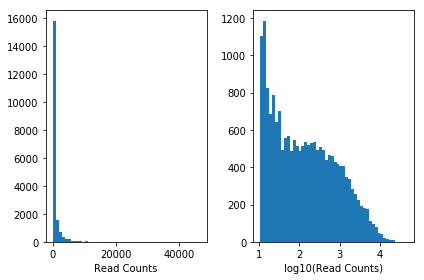


../../Data/MSS19/nextseq/Presort/MSS19_B1.txt
The Read Count Threshold is: 10
There are 11125290 total reads. 10623285 reads were analyzed at this threshold 95.49 percent
15997 of 18240 AD Barcode Seqs Match Designed AD Barcodes 
There are 1519 unique AD Barcodes
There are 431 unique AD Barcodes that match design
There are 18240 sequences with the correct structure
There are 3101 unique integration Barcodes
There are 109 sequences with errors in the RE site between Barcodes with 3311 reads


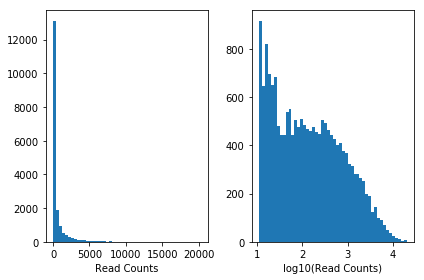


../../Data/MSS19/nextseq/Presort/MSS19_C.txt
The Read Count Threshold is: 10
There are 9912190 total reads. 9416038 reads were analyzed at this threshold 94.99 percent
18264 of 20010 AD Barcode Seqs Match Designed AD Barcodes 
There are 1332 unique AD Barcodes
There are 429 unique AD Barcodes that match design
There are 20010 sequences with the correct structure
There are 3201 unique integration Barcodes
There are 88 sequences with errors in the RE site between Barcodes with 3289 reads


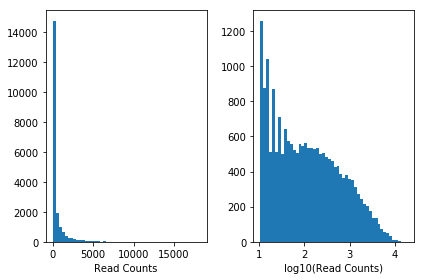

In [62]:
ReadCountThreshold =10
plotting = True

folder = '../../Data/MSS19/nextseq/Presort/'
AnalyzeInserts(folder+'MSS19_A.txt',ReadCountThreshold,returnDF=0,debugging=0,plotReadDepthHist=plotting)
AnalyzeInserts(folder+'MSS19_B1.txt',ReadCountThreshold,returnDF=0,debugging=0,plotReadDepthHist=plotting)
AnalyzeInserts(folder+'MSS19_C.txt',ReadCountThreshold,returnDF=0,debugging=0,plotReadDepthHist=plotting)

# AnalyzeInserts(folder+'MSS19_A.txt',10,returnDF=0,debugging=0,plotReadDepthHist=plotting)
# AnalyzeInserts(folder+'MSS19_A.txt',50,returnDF=0,debugging=0,plotReadDepthHist=plotting)
# AnalyzeInserts(folder+'MSS19_A.txt',100,returnDF=0,debugging=0,plotReadDepthHist=plotting)





In [63]:
ReadCountThreshold =10
plotting = 0
AnalyzeInserts('../../Data/MSS19/nextseq/Sort1/MSS19_01.txtsorted.txt',ReadCountThreshold,returnDF=0,debugging=0,plotReadDepthHist=plotting)
AnalyzeInserts('../../Data/MSS19/nextseq/Sort1/MSS19_02.txtsorted.txt',ReadCountThreshold,returnDF=0,debugging=0,plotReadDepthHist=plotting)
AnalyzeInserts('../../Data/MSS19/nextseq/Sort1/MSS19_03.txtsorted.txt',ReadCountThreshold,returnDF=0,debugging=0,plotReadDepthHist=plotting)
AnalyzeInserts('../../Data/MSS19/nextseq/Sort1/MSS19_04.txtsorted.txt',ReadCountThreshold,returnDF=0,debugging=0,plotReadDepthHist=plotting)
AnalyzeInserts('../../Data/MSS19/nextseq/Presort/MSS19_A.txtsorted.txt',ReadCountThreshold,returnDF=0,debugging=0,plotReadDepthHist=plotting)





../../Data/MSS19/nextseq/Sort1/MSS19_01.txtsorted.txt
The Read Count Threshold is: 10
There are 8978552 total reads. 8623600 reads were analyzed at this threshold 96.05 percent
11699 of 13772 AD Barcode Seqs Match Designed AD Barcodes 
There are 1468 unique AD Barcodes
There are 421 unique AD Barcodes that match design
There are 13772 sequences with the correct structure
There are 2824 unique integration Barcodes
There are 78 sequences with errors in the RE site between Barcodes with 1374 reads

../../Data/MSS19/nextseq/Sort1/MSS19_02.txtsorted.txt
The Read Count Threshold is: 10
There are 8235746 total reads. 7891633 reads were analyzed at this threshold 95.82 percent
12351 of 14001 AD Barcode Seqs Match Designed AD Barcodes 
There are 1288 unique AD Barcodes
There are 425 unique AD Barcodes that match design
There are 14001 sequences with the correct structure
There are 2899 unique integration Barcodes
There are 60 sequences with errors in the RE site between Barcodes with 1132 read

In [64]:
plotting=0
AnalyzeInserts('../../Data/MSS19/nextseq/Sort2/MSS19_05.txtsorted.txt',ReadCountThreshold,returnDF=0,debugging=0,plotReadDepthHist=plotting)
AnalyzeInserts('../../Data/MSS19/nextseq/Sort2/MSS19_06.txtsorted.txt',ReadCountThreshold,returnDF=0,debugging=0,plotReadDepthHist=plotting)
AnalyzeInserts('../../Data/MSS19/nextseq/Sort2/MSS19_07.txtsorted.txt',ReadCountThreshold,returnDF=0,debugging=0,plotReadDepthHist=plotting)
AnalyzeInserts('../../Data/MSS19/nextseq/Sort2/MSS19_08.txtsorted.txt',ReadCountThreshold,returnDF=0,debugging=0,plotReadDepthHist=plotting)
print '\n---\n'
AnalyzeInserts('../../Data/MSS19/nextseq/Presort/MSS19_B1.txtsorted.txt',ReadCountThreshold,returnDF=0,debugging=0,plotReadDepthHist=plotting)
AnalyzeInserts('../../Data/MSS19/nextseq/Presort/MSS19_B2.txtsorted.txt',ReadCountThreshold,returnDF=0,debugging=0,plotReadDepthHist=plotting)
AnalyzeInserts('../../Data/MSS19/nextseq/Presort/MSS19_B3.txtsorted.txt',ReadCountThreshold,returnDF=0,debugging=0,plotReadDepthHist=plotting)



../../Data/MSS19/nextseq/Sort2/MSS19_05.txtsorted.txt
The Read Count Threshold is: 10
There are 6936031 total reads. 6641852 reads were analyzed at this threshold 95.76 percent
11415 of 12722 AD Barcode Seqs Match Designed AD Barcodes 
There are 1216 unique AD Barcodes
There are 425 unique AD Barcodes that match design
There are 12722 sequences with the correct structure
There are 2766 unique integration Barcodes
There are 64 sequences with errors in the RE site between Barcodes with 2661 reads

../../Data/MSS19/nextseq/Sort2/MSS19_06.txtsorted.txt
The Read Count Threshold is: 10
There are 5094267 total reads. 4850521 reads were analyzed at this threshold 95.22 percent
11431 of 12116 AD Barcode Seqs Match Designed AD Barcodes 
There are 907 unique AD Barcodes
There are 430 unique AD Barcodes that match design
There are 12116 sequences with the correct structure
There are 2784 unique integration Barcodes
There are 34 sequences with errors in the RE site between Barcodes with 1455 reads

In [65]:
AnalyzeInserts('../../Data/MSS19/nextseq/Sort3/MSS19_09.txtsorted.txt',ReadCountThreshold,returnDF=0,debugging=0,plotReadDepthHist=plotting)
AnalyzeInserts('../../Data/MSS19/nextseq/Sort3/MSS19_10.txtsorted.txt',ReadCountThreshold,returnDF=0,debugging=0,plotReadDepthHist=plotting)
AnalyzeInserts('../../Data/MSS19/nextseq/Sort3/MSS19_11.txtsorted.txt',ReadCountThreshold,returnDF=0,debugging=0,plotReadDepthHist=plotting)
AnalyzeInserts('../../Data/MSS19/nextseq/Sort3/MSS19_12.txtsorted.txt',ReadCountThreshold,returnDF=0,debugging=0,plotReadDepthHist=plotting)
AnalyzeInserts('../../Data/MSS19/nextseq/Presort/MSS19_C.txtsorted.txt',ReadCountThreshold,returnDF=0,debugging=0,plotReadDepthHist=plotting)




../../Data/MSS19/nextseq/Sort3/MSS19_09.txtsorted.txt
The Read Count Threshold is: 10
There are 8331970 total reads. 7991532 reads were analyzed at this threshold 95.91 percent
12963 of 14640 AD Barcode Seqs Match Designed AD Barcodes 
There are 1317 unique AD Barcodes
There are 422 unique AD Barcodes that match design
There are 14640 sequences with the correct structure
There are 2871 unique integration Barcodes
There are 90 sequences with errors in the RE site between Barcodes with 3320 reads

../../Data/MSS19/nextseq/Sort3/MSS19_10.txtsorted.txt
The Read Count Threshold is: 10
There are 9616263 total reads. 9207216 reads were analyzed at this threshold 95.75 percent
14202 of 16110 AD Barcode Seqs Match Designed AD Barcodes 
There are 1383 unique AD Barcodes
There are 428 unique AD Barcodes that match design
There are 16110 sequences with the correct structure
There are 2983 unique integration Barcodes
There are 97 sequences with errors in the RE site between Barcodes with 3988 read

In [66]:
AnalyzeInserts('../../Data/MSS19/nextseq/Sort4/MSS19_13.txtsorted.txt',ReadCountThreshold,returnDF=0,debugging=0,plotReadDepthHist=plotting)
AnalyzeInserts('../../Data/MSS19/nextseq/Sort4/MSS19_14.txtsorted.txt',ReadCountThreshold,returnDF=0,debugging=0,plotReadDepthHist=plotting)
AnalyzeInserts('../../Data/MSS19/nextseq/Sort4/MSS19_15.txtsorted.txt',ReadCountThreshold,returnDF=0,debugging=0,plotReadDepthHist=plotting)
AnalyzeInserts('../../Data/MSS19/nextseq/Sort4/MSS19_16.txtsorted.txt',ReadCountThreshold,returnDF=0,debugging=0,plotReadDepthHist=plotting)



../../Data/MSS19/nextseq/Sort4/MSS19_13.txtsorted.txt
The Read Count Threshold is: 10
There are 7948296 total reads. 7607116 reads were analyzed at this threshold 95.71 percent
13164 of 14596 AD Barcode Seqs Match Designed AD Barcodes 
There are 1232 unique AD Barcodes
There are 428 unique AD Barcodes that match design
There are 14596 sequences with the correct structure
There are 2947 unique integration Barcodes
There are 71 sequences with errors in the RE site between Barcodes with 2400 reads

../../Data/MSS19/nextseq/Sort4/MSS19_14.txtsorted.txt
The Read Count Threshold is: 10
There are 6067808 total reads. 5789603 reads were analyzed at this threshold 95.42 percent
13073 of 13883 AD Barcode Seqs Match Designed AD Barcodes 
There are 961 unique AD Barcodes
There are 427 unique AD Barcodes that match design
There are 13883 sequences with the correct structure
There are 2932 unique integration Barcodes
There are 56 sequences with errors in the RE site between Barcodes with 1537 reads

In [67]:
AnalyzeInserts('../../Data/MSS19/nextseq/BonusSorts/MSS19_17.txtsorted.txt',ReadCountThreshold,returnDF=0,debugging=0,plotReadDepthHist=plotting)
AnalyzeInserts('../../Data/MSS19/nextseq/BonusSorts/MSS19_18.txtsorted.txt',ReadCountThreshold,returnDF=0,debugging=0,plotReadDepthHist=plotting)



../../Data/MSS19/nextseq/BonusSorts/MSS19_17.txtsorted.txt
The Read Count Threshold is: 10
There are 7186841 total reads. 6881455 reads were analyzed at this threshold 95.75 percent
8206 of 9953 AD Barcode Seqs Match Designed AD Barcodes 
There are 1401 unique AD Barcodes
There are 415 unique AD Barcodes that match design
There are 9953 sequences with the correct structure
There are 2480 unique integration Barcodes
There are 110 sequences with errors in the RE site between Barcodes with 3359 reads

../../Data/MSS19/nextseq/BonusSorts/MSS19_18.txtsorted.txt
The Read Count Threshold is: 10
There are 6872373 total reads. 6563086 reads were analyzed at this threshold 95.50 percent
7203 of 8752 AD Barcode Seqs Match Designed AD Barcodes 
There are 1347 unique AD Barcodes
There are 416 unique AD Barcodes that match design
There are 8752 sequences with the correct structure
There are 2353 unique integration Barcodes
There are 90 sequences with errors in the RE site between Barcodes with 5280

In [69]:
ReadCountThreshold =0
MSS19_presortA_dict  = AnalyzeInserts('../../Data/MSS19/nextseq/Presort/MSS19_A.txtsorted.txt',ReadCountThreshold,returnDF=0,debugging=0,plotReadDepthHist=plotting,returnFullSeq2CountDict=1)
MSS19_presortB1_dict = AnalyzeInserts('../../Data/MSS19/nextseq/Presort/MSS19_B1.txtsorted.txt',ReadCountThreshold,returnDF=0,debugging=0,plotReadDepthHist=plotting,returnFullSeq2CountDict=1)
MSS19_presortB2_dict = AnalyzeInserts('../../Data/MSS19/nextseq/Presort/MSS19_B2.txtsorted.txt',ReadCountThreshold,returnDF=0,debugging=0,plotReadDepthHist=plotting,returnFullSeq2CountDict=1)
MSS19_presortB3_dict = AnalyzeInserts('../../Data/MSS19/nextseq/Presort/MSS19_B3.txtsorted.txt',ReadCountThreshold,returnDF=0,debugging=0,plotReadDepthHist=plotting,returnFullSeq2CountDict=1)
MSS19_presortC_dict  = AnalyzeInserts('../../Data/MSS19/nextseq/Presort/MSS19_C.txtsorted.txt',ReadCountThreshold,returnDF=0,debugging=0,plotReadDepthHist=plotting,returnFullSeq2CountDict=1)



MSS19_08_dict  = AnalyzeInserts('../../Data/MSS19/nextseq/Sort2/MSS19_08.txtsorted.txt',ReadCountThreshold,returnDF=0,debugging=0,plotReadDepthHist=plotting,returnFullSeq2CountDict=1)
MSS19_16_dict = AnalyzeInserts('../../Data/MSS19/nextseq/Sort4/MSS19_16.txtsorted.txt',ReadCountThreshold,returnDF=0,debugging=0,plotReadDepthHist=plotting,returnFullSeq2CountDict=1)



print len(MSS19_presortA_dict)
print len(MSS19_presortB1_dict)
print len(MSS19_presortB2_dict)
print len(MSS19_presortB3_dict)
print len(MSS19_presortC_dict)


../../Data/MSS19/nextseq/Presort/MSS19_A.txtsorted.txt
The Read Count Threshold is: 0
There are 13360343 total reads. 13299761 reads were analyzed at this threshold 99.55 percent
77170 of 396967 AD Barcode Seqs Match Designed AD Barcodes 
There are 73916 unique AD Barcodes
There are 432 unique AD Barcodes that match design
There are 396967 sequences with the correct structure
There are 4681 unique integration Barcodes
There are 45923 sequences with errors in the RE site between Barcodes with 60582 reads

../../Data/MSS19/nextseq/Presort/MSS19_B1.txtsorted.txt
The Read Count Threshold is: 0
There are 11125290 total reads. 11073742 reads were analyzed at this threshold 99.54 percent
69594 of 353457 AD Barcode Seqs Match Designed AD Barcodes 
There are 69819 unique AD Barcodes
There are 435 unique AD Barcodes that match design
There are 353457 sequences with the correct structure
There are 4552 unique integration Barcodes
There are 39060 sequences with errors in the RE site between Barco

In [71]:
MSS19_08_dict  = AnalyzeInserts('../../Data/MSS19/nextseq/Sort2/MSS19_08.txtsorted.txt',ReadCountThreshold,returnDF=0,debugging=0,plotReadDepthHist=plotting,returnFullSeq2CountDict=1)
MSS19_16_dict = AnalyzeInserts('../../Data/MSS19/nextseq/Sort4/MSS19_16.txtsorted.txt',ReadCountThreshold,returnDF=0,debugging=0,plotReadDepthHist=plotting,returnFullSeq2CountDict=1)
MSS19_17_dict  = AnalyzeInserts('../../Data/MSS19/nextseq/BonusSorts/MSS19_17.txtsorted.txt',ReadCountThreshold,returnDF=0,debugging=0,plotReadDepthHist=plotting,returnFullSeq2CountDict=1)
MSS19_18_dict = AnalyzeInserts('../../Data/MSS19/nextseq/BonusSorts/MSS19_18.txtsorted.txt',ReadCountThreshold,returnDF=0,debugging=0,plotReadDepthHist=plotting,returnFullSeq2CountDict=1)





../../Data/MSS19/nextseq/Sort2/MSS19_08.txtsorted.txt
The Read Count Threshold is: 0
There are 7846482 total reads. 7810303 reads were analyzed at this threshold 99.54 percent
50861 of 236273 AD Barcode Seqs Match Designed AD Barcodes 
There are 55276 unique AD Barcodes
There are 430 unique AD Barcodes that match design
There are 236273 sequences with the correct structure
There are 4389 unique integration Barcodes
There are 26504 sequences with errors in the RE site between Barcodes with 36179 reads

../../Data/MSS19/nextseq/Sort4/MSS19_16.txtsorted.txt
The Read Count Threshold is: 0
There are 6712474 total reads. 6680903 reads were analyzed at this threshold 99.53 percent
39367 of 207725 AD Barcode Seqs Match Designed AD Barcodes 
There are 55289 unique AD Barcodes
There are 429 unique AD Barcodes that match design
There are 207725 sequences with the correct structure
There are 4305 unique integration Barcodes
There are 21536 sequences with errors in the RE site between Barcodes wit

There are 1430628 entries


/Users/Max/Library/Python/2.7/lib/python/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log2


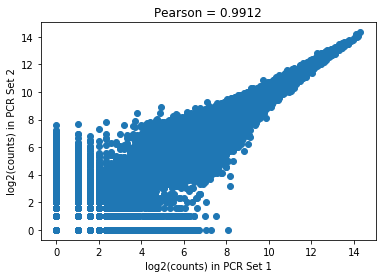

There are 1430628 entries


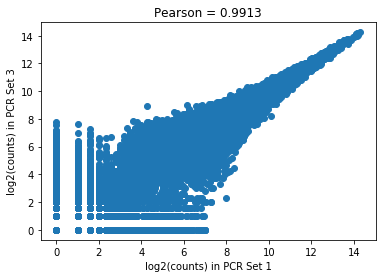

There are 1430628 entries


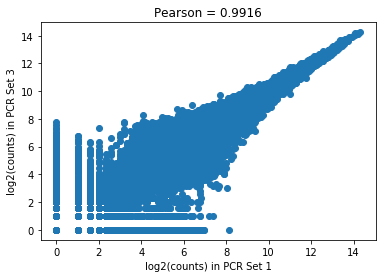

There are 1430628 entries


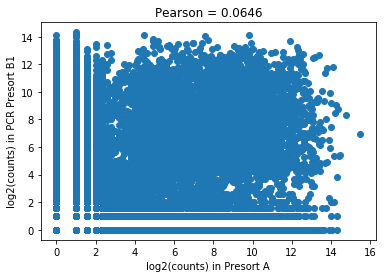

There are 1430628 entries


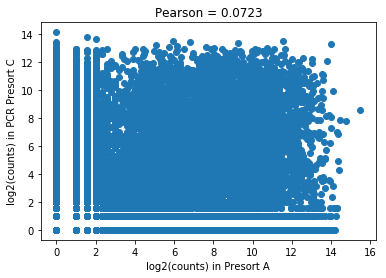

There are 1430628 entries


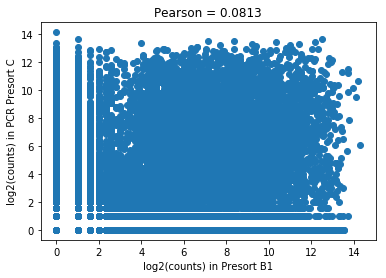

There are 584887 entries


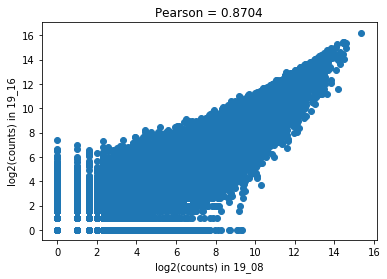

In [74]:
def plot2dicts(DICT1,DICT2,xlabeltext,ylabeltext):
    xs,ys = [],[]
    allseqs = DICT1.keys()
    allseqs.extend(DICT2.keys())
    for entry in set(allseqs):
        xs.append(DICT1[entry])
        ys.append(DICT2[entry])
    print 'There are %i entries'% len(xs)
    plt.scatter(np.log2(xs),np.log2(ys))
    plt.xlabel(xlabeltext)
    plt.ylabel(ylabeltext)
    corrs = np.corrcoef(xs,ys)
    plt.title('Pearson = %.4f'%corrs[0,1])
    plt.show()

plot2dicts(MSS19_presortB1_dict,MSS19_presortB2_dict,'log2(counts) in PCR Set 1','log2(counts) in PCR Set 2')
plot2dicts(MSS19_presortB1_dict,MSS19_presortB3_dict,'log2(counts) in PCR Set 1','log2(counts) in PCR Set 3')
plot2dicts(MSS19_presortB2_dict,MSS19_presortB3_dict,'log2(counts) in PCR Set 1','log2(counts) in PCR Set 3')

plot2dicts(MSS19_presortA_dict,MSS19_presortB1_dict,'log2(counts) in Presort A','log2(counts) in PCR Presort B1')
plot2dicts(MSS19_presortA_dict,MSS19_presortC_dict,'log2(counts) in Presort A' ,'log2(counts) in PCR Presort C')
plot2dicts(MSS19_presortB1_dict,MSS19_presortC_dict,'log2(counts) in Presort B1','log2(counts) in PCR Presort C')

plot2dicts(MSS19_08_dict,MSS19_16_dict ,'log2(counts) in 19_08','log2(counts) in 19_16')
# plot2dicts(MSS19_08_dict,MSS19_17_dict ,'log2(counts) in 19_08','log2(counts) in 19_17')

# Build a DataFrame with compound Barcodes for downstream analysis


In [118]:
folder = '../../Data/MSS19/nextseq/Presort/'
Sort1_presort = AnalyzeInserts(folder+'MSS19_A.txtsorted.txt',ReadCountThreshold,returnDF=1,debugging=0,plotReadDepthHist=plotting)
Sort2_presort = AnalyzeInserts(folder+'MSS19_B1.txtsorted.txt',ReadCountThreshold,returnDF=1,debugging=0,plotReadDepthHist=plotting)
Sort3_presort = AnalyzeInserts(folder+'MSS19_C.txtsorted.txt',ReadCountThreshold,returnDF=1,debugging=0,plotReadDepthHist=plotting)

Presort_seq2ADBC_Dict = dict(zip(Sort1_presort.FullSeqs,Sort1_presort.ADBCs))
Presort2_seq2ADBC_Dict = dict(zip(Sort2_presort.FullSeqs,Sort2_presort.ADBCs))
Presort_seq2ADBC_Dict.update(Presort2_seq2ADBC_Dict)
Presort3_seq2ADBC_Dict = dict(zip(Sort3_presort.FullSeqs,Sort3_presort.ADBCs))
Presort_seq2ADBC_Dict.update(Presort3_seq2ADBC_Dict)



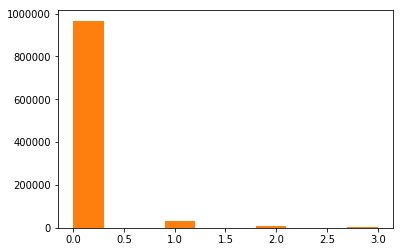

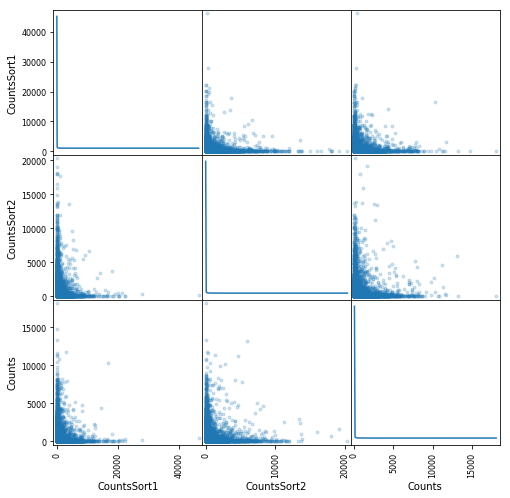

,CountsSort1,CountsSort2,Counts
CountsSort1,1.000000,0.077687,0.078258
CountsSort2,0.077687,1.000000,0.106332
Counts,0.078258,0.106332,1.000000


In [122]:
PresortDFtemp = Sort1_presort.merge(Sort2_presort,how='outer',on='FullSeqs',suffixes=('Sort1','Sort2'))
PresortDF = PresortDFtemp.merge(Sort3_presort,how='outer',on='FullSeqs',suffixes=('Sort1','Sort3'))
from pandas.tools.plotting import scatter_matrix
scatter_matrix(PresortDF, alpha=0.2, figsize=(8, 8), diagonal='kde')
plt.savefig('Figures/MSS19_PresortAbundancs.png')
plt.show()
PresortDF.corr()

# PresortDF

In [121]:
# find number of replicates each BC is in over a threshold
thresh = 10
Nreps =np.zeros_like(PresortDF.Counts)
cols = ['CountsSort1','CountsSort2','Counts']
for col in cols:
    temp = PresortDF[col]>thresh
    Nreps +=temp
plt.hist(Nreps)
indx = Nreps>0
print sum(indx)

# Make a 'pruned' DF with common BCs only
PrunedPresortDF = PresortDF[indx]
PrunedPresortDF = PrunedPresortDF.reset_index()
# PrunedPresortDF = PrunedPresortDF.fillna('')

#fill in the ADBCs
# make DF with 'ADseq'=ADBC 'Barcode'==CompoundBarcode and DNAseq 
columns = ['CountsSort1','CountsSort2']
ExportDF = PrunedPresortDF[columns]
ExportDF['CountsSort3']=PrunedPresortDF['Counts']
ExportDF['Barcode']=PrunedPresortDF['FullSeqs']
temp = PrunedPresortDF['FullSeqs']
ExportDF['ADBC']= temp.map(Presort_seq2ADBC_Dict)
ExportDF['ADseq']=ExportDF.ADBC

ExportDF.to_pickle('../KeySupportFiles/CompositeBarcodesDF')
ExportDF



44077


/Users/Max/Library/Python/2.7/lib/python/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Max/Library/Python/2.7/lib/python/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Max/Library/Python/2.7/lib/python/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pan

,CountsSort1,CountsSort2,CountsSort3,Barcode,ADBC,ADseq
0,463.0,NaN,177.0,TTCTTCTGAAAAAAAGCTAGCAACAACGGTCTCGAG,AACAACGGT,AACAACGGT
1,1.0,15.0,NaN,TTCTTCTGAAAAAAAGCTAGCAATCGACTCCTCGAG,AATCGACTC,AATCGACTC
2,564.0,NaN,11.0,TTCTTCTGAAAAAAAGCTAGCACGTATCGGCTCGAG,ACGTATCGG,ACGTATCGG
3,1.0,NaN,128.0,TTCTTCTGAAAAAAAGCTAGCACTTGGAGGCTCGAG,ACTTGGAGG,ACTTGGAGG
4,1.0,45.0,NaN,TTCTTCTGAAAAAAAGCTAGCCAGCCTCAACTCGAG,CAGCCTCAA,CAGCCTCAA
5,242.0,120.0,43.0,TTCTTCTGAAAAAAAGCTAGCCGTAATGTCCTCGAG,CGTAATGTC,CGTAATGTC
6,10.0,20.0,1.0,TTCTTCTGAAAAAAAGCTAGCGATTAGAGACTCGAG,GATTAGAGA,GATTAGAGA
7,2932.0,2877.0,2.0,TTCTTCTGAAAAAAAGCTAGCGATTAGCGACTCGAG,GATTAGCGA,GATTAGCGA
8,2.0,6.0,32.0,TTCTTCTGAAAAAAAGCTAGCTACAGGAGACTCGAG,TACAGGAGA,TACAGGAGA
9,75.0,1.0,1.0,TTCTTCTGAAAAAACGCTAGCAACAACGGTCTCGAG,AACAACGGT,AACAACGGT


In [102]:
LegacyDF_original = pd.read_pickle('../../Analysis_LC2_AcidBlobLibrary/AnalysisSuportFiles/Pickle_LC2_BCDF') # changed 20200210

LegacyDF_original
PrunedPresortDF
# temp = PrunedPresortDF.ADBCs+PrunedPresortDF.ADBCsSort1+PrunedPresortDF.ADBCsSort2
# temp

,index,ADBCsSort1,CountsSort1,FullSeqs,InsertionBCsSort1,ADBCsSort2,CountsSort2,InsertionBCsSort2,ADBCs,Counts,InsertionBCs
0,38,AACAACGGT,463,TTCTTCTGAAAAAAAGCTAGCAACAACGGTCTCGAG,AAAAAA,,,,AACAACGGT,177,AAAAAA
1,101,AATCGACTC,1,TTCTTCTGAAAAAAAGCTAGCAATCGACTCCTCGAG,AAAAAA,AATCGACTC,15,AAAAAA,,,
2,180,ACGTATCGG,564,TTCTTCTGAAAAAAAGCTAGCACGTATCGGCTCGAG,AAAAAA,,,,ACGTATCGG,11,AAAAAA
3,194,ACTTGGAGG,1,TTCTTCTGAAAAAAAGCTAGCACTTGGAGGCTCGAG,AAAAAA,,,,ACTTGGAGG,128,AAAAAA
4,374,CAGCCTCAA,1,TTCTTCTGAAAAAAAGCTAGCCAGCCTCAACTCGAG,AAAAAA,CAGCCTCAA,45,AAAAAA,,,
5,554,CGTAATGTC,242,TTCTTCTGAAAAAAAGCTAGCCGTAATGTCCTCGAG,AAAAAA,CGTAATGTC,120,AAAAAA,CGTAATGTC,43,AAAAAA
6,651,GATTAGAGA,10,TTCTTCTGAAAAAAAGCTAGCGATTAGAGACTCGAG,AAAAAA,GATTAGAGA,20,AAAAAA,GATTAGAGA,1,AAAAAA
7,656,GATTAGCGA,2932,TTCTTCTGAAAAAAAGCTAGCGATTAGCGACTCGAG,AAAAAA,GATTAGCGA,2877,AAAAAA,GATTAGCGA,2,AAAAAA
8,746,TACAGGAGA,2,TTCTTCTGAAAAAAAGCTAGCTACAGGAGACTCGAG,AAAAAA,TACAGGAGA,6,AAAAAA,TACAGGAGA,32,AAAAAA
9,805,AACAACGGT,75,TTCTTCTGAAAAAACGCTAGCAACAACGGTCTCGAG,AAAAAC,AACAACGGT,1,AAAAAC,AACAACGGT,1,AAAAAC


In [114]:
# if np.isnan(temp[0]):
#     ADBC = temp[0]
# elif np.isnan(temp[1]):
#     ADBC = temp[1]
# else:
#     ADBC = temp[2]
# ADBC
temp

ADBCsSort1    CCGTGTTGT
ADBCsSort2    CCGTGTTGT
ADBCs               NaN
Name: 18627, dtype: object

In [79]:
# FILENAMES = [
#     'Data/CheckLC5_2xBC_step2_MaxiPrep1_PCR1.txtsorted_UpGrepOnly.txt',
#     'Data/CheckLC5_2xBC_step2_MaxiPrep1_PCR2.txtsorted_UpGrepOnly.txt',
#     'Data/CheckLC5_2xBC_step2_MaxiPrep2_PCR1.txtsorted_UpGrepOnly.txt',
#     'Data/CheckLC5_2xBC_step2_MaxiPrep2_PCR2.txtsorted_UpGrepOnly.txt',
# ]
# masterDF = pd.DataFrame({'DesignedInsert':DesignedInserts,'DesignedBCs':DesignedBCs,'DesignedADs':DesignedADs})
# for temp in FILENAMES:
#     DF = AnalyzeInserts(temp,1,returnDF=1,debugging=0, plotReadDepthHist=0)
#     tempDict = dict(zip(DF['FullInserts'],DF['Counts']))
#     colname = temp.split('/')[-1]
#     colname = colname.split('_')[3]
#     tempDF =  masterDF.DesignedInsert
#     masterDF[colname]= tempDF.map(tempDict)


In [80]:
# from pandas.tools.plotting import scatter_matrix
# cols = ['sample1','sample2', 'sample3', 'direct1', 'direct2', 'direct3']
# tempDF = masterDF[cols]
# sumDF = tempDF.sum(1)
# tempDF = tempDF.apply(np.log10)
# scatter_matrix(tempDF, alpha=0.2, figsize=(8, 8), diagonal='kde')
# plt.show()
# tempDF.corr()


In [81]:
# indx = (masterDF.sample1>0)&(masterDF.sample2>0)&(masterDF.sample3>0)#
# indx = (masterDF.direct1>0)&(masterDF.direct2>0)&(masterDF.direct3>0)
# # indx = (masterDF.sample1>0)+(masterDF.sample2>0)+(masterDF.sample3>0)+(masterDF.direct1>0)+(masterDF.direct2>0)+(masterDF.direct3>0)

# # print indx
# print sum(indx)

# # for col in cols:
# #     plt

# np.log10
# masterDF.columns
# # DF
# # masterDF.



# bob = np.log10(sumDF.values)
# bob = bob[bob>0]
# plt.hist(bob,30)
# plt.xlabel('Log10(abundance)'), plt.ylabel('Count')
# plt.show()

In [82]:
# AnalyzeInserts('data/2x150/LC5_s1_2xBCs_sample1_direct_counts.txt',1,returnDF=0,debugging=0, plotReadDepthHist=1)
# AnalyzeInserts('data/2x150/LC5_s1_2xBCs_sample1_direct_counts.txt',10,returnDF=0,debugging=0, plotReadDepthHist=1)
# AnalyzeInserts('data/2x150/LC5_s1_2xBCs_sample1_direct_counts.txt',32,returnDF=0,debugging=0, plotReadDepthHist=1)

AnalyzeInserts('data/2x150/LC5_s1_2xBCs_sample1_direct_counts.txt',10,returnDF=0,debugging=0, plotReadDepthHist=1)





IOError: [Errno 2] No such file or directory: 'data/2x150/LC5_s1_2xBCs_sample1_direct_counts.txt'